# Computing Structural Relaxation

## What is structural relaxation

Structural relaxation is a key concept for studying
the dynamics of supercooled liquids,
being the most fundamental relaxation process (Angell 2000).
It is the process by which
a liquid forgets it's structure from some earlier time (Edger 1996),
and can be measured experimentally through
quasi-elastic neutron scattering or photon correlation spectroscopy.
These experimental techniques are measuring
the density-density correlations of the liquid,
which can be represented by either
the density autocorrelation function,
or as is more common the intermediate scattering function $F(k, t)$.
This function is represented as

$$ F(k, t) = \frac{1}{N}\langle \sum_j^N \exp{
    i\mathbf{k} \cdot [\mathbf{r}_j(0) - \mathbf{r}_j(t)]
} \rangle $$

where the angle brackets denote the averaging over
many initial configurations.

The intermediate scattering function is
the spatial Fourier transform of the
van Hove correlation function $G(r, t)$
which is a much quantity to calculate
from simulated systems.
The van Hove correlation function is given as;

$$G(r, t) = \frac{1}{4\pi r^2 \Delta r} \langle \delta[r_i(t) - r_i(0) - r] \rangle$$

Instead of computing the intermediate scattering function
for all values of the wave-vector $k$,
just a single value for the wave-vector is tracked through time.
The choice of this wave-vector is chosen as
peak of the static structure factor $S(k)$
as this is the largest and so has the biggest response.
The static structure factor $S(k)$
is the time independent version of
the intermediate scattering function.
The structure factor is computed from the
radial distribution function $G(r)$,
being the time independent part of the
van Hove correlation function.

The radial distribution function $G(r)$
is computed as

$$ G(r) = \frac{1}{N\rho} \sum_i^N \sum_{j\ne i}^N \delta[r - r_{ij}] $$

while the static structure factor $S(k)$
is the Fourier transform of
the radial distribution function

$$ S(q) = 1 + \rho \int dr e^{-iqr} [G(r) - 1] $$

While computing the intermediate scattering function
is one method of measuring the structural relaxation,
it requires calculating the distances
between all sets of particles which takes a lot of computation.
An alternate method of computing structural relaxation
proposed by Widmer-Cooper and Harrowell (Widmer-Cooper2009)
uses the displacements of particles from their initial positions

$$ F_d(t) = \frac{1}{N} \langle \sum_i w_i(d,t) \rangle $$

where $w_i(d,t)=1$ when a particle is within a distance $d$
of the initial position at time $t$ and zero otherwise.
The value of $d$ chosen in this paper is

$$ d = \frac{\pi}{2k_{bragg}} $$

where $k_{bragg}$ is the value of the wave vector
at the first maximum of the intermediate scattering function.

## Computing the structural relaxation

This is a notebook for computing
the structural relaxation of
a molecular dynamics trajectory
which contains 675 trimer molecules.

### Loading the trajectory

The first step here is to load the trajectory for analysis.
For this step I have written a helper function
to make this process simpler
which is contained within the `sdanalysis` package.

In [1]:
# Import sdanalysis to read input files
import sdanalysis

The input file which we want to read
is for an exponential sequence of steps
at a relatively high temperature
so that we don't have to read
too many steps of the trajectory,
that is, everything will go faster.
The temperature which I am choosing will be 0.80
at a pressure of 1.0

In [2]:
temperature = 0.80
pressure = 1.00

# This is a python standard library module which makes handling paths
# significantly simpler
from pathlib import Path

# Path to the directory holding the input files
data_directory = Path("../data/simulations/trimer/output")

filename = data_directory / f"trajectory-Trimer-P{pressure:.2f}-T{temperature:.2f}.gsd"

With the path of the file to read
we now need to access the first configuration of the trajectory
which can be used to calculate the
radial distribution function.
The function `sdanalysis.open_trajectory` returns an iterator,
so to get the first snapshot from the file
we have to use the `next` function.

In [3]:
init_snapshot = next(sdanalysis.open_trajectory(filename))

Getting the positions of particles
from the snapshot can be done by calling the
`position` property

In [4]:
init_snapshot.position

array([[-23.3865   ,  -9.239151 ,   0.       ],
       [  3.9658844, -22.591003 ,   0.       ],
       [ 12.305967 ,  14.258924 ,   0.       ],
       ...,
       [ 13.643798 , -16.695618 ,   0.       ],
       [ 16.10849  , -11.522567 ,   0.       ],
       [ 25.02609  , -14.913969 ,   0.       ]], dtype=float32)

Note that these are the positions for the
center-of-mass for each of the 625 molecules.
The positions of the individual particles
can be calculated from
the positions and orientations,
where the orientations in quaternion form
are accessed through the `orientation` property.

Additionally the description of box can be retrieved
with the `box` property

In [5]:
init_snapshot.box

array([62.86591, 62.86591,  1.     ,  0.     ,  0.     ,  0.     ],
      dtype=float32)

We can combine these properties of
the initial snapshot and calculate the
radial distribution function.

### Computing the radial distribution function

The Glotzer group have developed a python package
called [freud](https://github.com/glotzerlab/freud) for the analysis of
molecular dynamics trajectories.
This package includes a function
for computing the radial distribution function
[`freud.density.RDF`](https://freud.readthedocs.io/en/stable/density.html#freud.density.RDF)
I will be using this function for computing $G(r)$

In [6]:
# import the freud library
import freud

# The simulation box of the snapshot
box = freud.box.Box(
    Lx=init_snapshot.box[0],
    Ly=init_snapshot.box[1],
    is2D=True,
)

# This is the size of the bins for the distribution function
dr=0.1
# The maximum radius to integrate to, this has to be smaller than half the
# width of the box.
rmax=20
rdf = freud.density.RDF(rmax=rmax, dr=dr)

rdf.compute(box, init_snapshot.position)

This has calculated the radial distribution function
for the snapshot,
which we can plot using matplotlib.

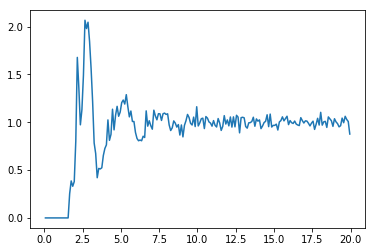

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(rdf.R, rdf.RDF)

It is possible to read many configurations
and use the function `rdf.accumulate`
instead of `rdf.compute`
to generate a smoother curve.

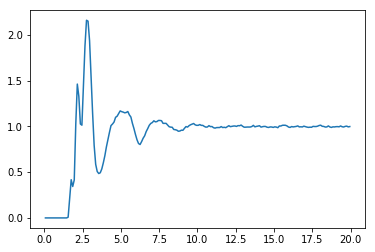

In [8]:
# This is the size of the bins for the distribution function
dr=0.1
# The maximum radius to integrate to, this has to be smaller than half the
# width of the box.
rmax=20
rdf = freud.density.RDF(rmax=rmax, dr=dr)

# Average over the first `num_frames` frames
num_frames = 1000
for index, snapshot in enumerate(sdanalysis.open_trajectory(filename)):
    if index > num_frames:
        break

    box = freud.box.Box(
        Lx=snapshot.box[0],
        Ly=snapshot.box[1],
        is2D=True,
    )
    rdf.accumulate(box, snapshot.position)

plt.plot(rdf.R, rdf.RDF)

### Computing the structure factor

Now that we have nicely computed the radial distribution function
we can convert it to the structure factor $S(k)$
the equation for which is below for reference.

$$ S(k) = 1 + \rho \int dr e^{-ikr} [G(r) - 1] $$

Although computing the structure factor
is supposed to be a Fourier transform,
from [Wikipedia](https://en.wikipedia.org/wiki/Radial_distribution_function#The_structure_factor)
we can invoke the isotropy of the liquid giving;

$$ S(k) = 1 + 4 \pi \rho \frac{1}{k} \int dr r \sin(qr) [g(r) - 1] $$

where $\rho$ is the number density of the liquid.

This can be calculated

In [9]:
import numpy

def static_structure_factor(
    rdf: freud.density.RDF,
    wave_number: float,
    num_particles: int
):
    dr = rdf.R[1] - rdf.R[0]
    integral = dr * numpy.sum(
        (rdf.RDF - 1) *
        rdf.R *
        numpy.sin(wave_number * rdf.R)
    )
    density = num_particles / rdf.box.volume
    return 1 + 4 * numpy.pi * density / wave_number * integral

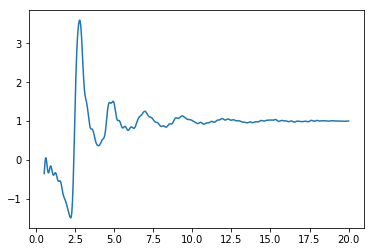

In [10]:
ssf = []
x = numpy.linspace(0.5, 20, 1000)
for value in x:
    ssf.append(static_structure_factor(rdf, value, snapshot.num_mols))

plt.plot(x, ssf)

In [11]:
wave_number = x[numpy.argmax(ssf)]
wave_number

2.7837837837837838

In [12]:
k_bragg = numpy.pi/(2*wave_number)
k_bragg

0.5642666416641862

In the numpy implementation the first N/2 wave-vectors are the positive ones
while the last N/2 are the negative ones.
To find the wave-vector which is most prominent
and we consequently want to track
for the time dependent scattering function
we can find the position of the maximum value

Here we see that the maximum is 2.78,
so we want a wave-vector $k = 2.78$

### Checking for correctness

As a check that the calculations of
the radial distribution function,
the static structure factor,
and the appropriate wave number
are all correct.
We can scale all the positions by a constant value,
and the calculated values should reflect this.

In [13]:
def scale_trajectory(filename: Path, scale_factor: int):
    # This is the size of the bins for the distribution function
    dr=0.1 * scale_factor
    # The maximum radius to integrate to, this has to be smaller than half the
    # width of the box.
    rmax=20 * scale_factor
    rdf = freud.density.RDF(rmax=rmax, dr=dr)

    # Average over the first `num_frames` frames
    num_frames = 1000
    for index, snapshot in enumerate(sdanalysis.open_trajectory(filename)):
        if index > num_frames:
            break

        box = freud.box.Box(
            Lx=snapshot.box[0] * scale_factor,
            Ly=snapshot.box[1] * scale_factor,
            is2D=True,
        )
        rdf.accumulate(box, snapshot.position * scale_factor)

    return rdf

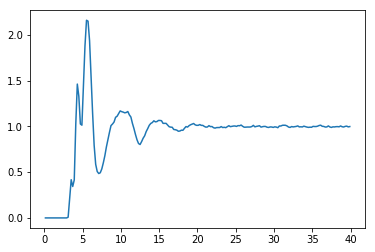

In [14]:
scale_factor = 2

rdf_doubled = scale_trajectory(filename, scale_factor)

plt.plot(rdf_doubled.R, rdf_doubled.RDF)

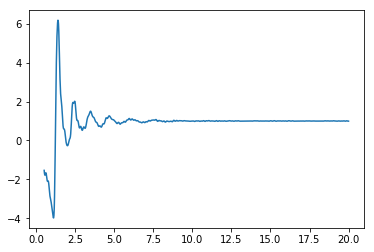

In [15]:
ssf_doubled = []
x = numpy.linspace(0.5, 20, 1000)
num_particles = snapshot.num_mols
for value in x:
    ssf_doubled.append(static_structure_factor(rdf_doubled, value, num_particles))

plt.plot(x, ssf_doubled)

In [16]:
wave_number_doubled = x[numpy.argmax(ssf_doubled)]
wave_number_doubled

1.3783783783783785

In [17]:
k_bragg_doubled = numpy.pi/(2*wave_number_doubled)
k_bragg_doubled

1.1395973351257092

In [18]:
wave_number_doubled / wave_number

0.4951456310679612

In [19]:
k_bragg_doubled / k_bragg

2.019607843137255

We can see above that when we have doubled the distance between particles
the wave number is half of what it was originally,
while the characteristic length scale $k_{bragg}$
is now double the original value.

This demonstrates that the calculations do indeed appear
to be working correctly.

### Calculating the intermediate scattering function

The intermediate scattering function is given by

$$ F(k, t) = \frac{1}{N}\langle \sum_j^N \exp{
    i\mathbf{k} \cdot [\mathbf{r}_j(0) - \mathbf{r}_j(t)]
} \rangle $$

where the scalar $k$ is the wave number,
and the vector $\mathbf{k}$ is the wave vector.

Since the intermediate scattering function
is a measure of the scattering from a radiation source,
since we have an isotropic liquid,
where all orientations are equivalent,
by rotating the incident radiation,
that is choosing a range of values for the wave-vector
around the unit circle,
we can get a much better representation
of the relaxation of the liquid.
This transformation gives $\mathbf{k}$ the form;

$$ \mathbf{k} = k \frac{1}{M}\sum_{a=1}^M [\cos\left(a\frac{2\pi}{M}\right), \sin\left(a\frac{2\pi}{M}\right)] $$

Where the sum is over $N$ values of
the angle $\theta_i$ which ranges in value from $0$ to $2\pi$.

Substituting this value for $\mathbf{k}$
into our expression for the intermediate scattering function
we get

$$
F(k, t) = \frac{1}{NM} \left \langle \sum_j^N\sum_{a=1}^M \exp \left (
ik \left[\cos\left(a\frac{2\pi}{M}\right), \sin \left(a\frac{2\pi}{M} \right) \right] 
\cdot 
[\Delta x_{j}(t), \Delta y_{j}(t)]
\right ) \right \rangle
$$

Additionally since we can only use the real component
this can be further simplified to

$$
F(k, t) = \frac{1}{NM} \left \langle \sum_j^N\sum_{a=1}^M \cos \left (
k \left[\cos\left(a\frac{2\pi}{M}\right), \sin \left(a\frac{2\pi}{M} \right) \right] 
\cdot 
[\Delta x_{j}(t), \Delta y_{j}(t)]
\right ) \right \rangle
$$

Additionally to simplify everything once more,
and since I am only using a single starting configuration here,
I am going to use the angle brackets to
denote a mean over all particles and angles.
Enabling me to write

$$
F(k, t) = \left \langle \cos \left (
k \left[\cos\left(a\frac{2\pi}{M}\right), \sin \left(a\frac{2\pi}{M} \right) \right] 
\cdot 
[\Delta x_{j}(t), \Delta y_{j}(t)]
\right ) \right \rangle
$$

This can then be converted to a python function:

In [20]:
from functools import lru_cache

# This decorator is what enables the caching of this function,
# making this function 100 times faster for subsequent exectutions
@lru_cache()
def create_wave_vector(wave_number: float, angular_resolution: int):
    """Covnert a wave number into a radially symmetric wave vector

    This calculates the values of cos and sin :math:`\theta` for `angular_resolution`
    values of :math:`\theta` between 0 and :math:`2\pi`.

    The results of this function are cached, so these values only need to be computed
    a single time, the rest of the time they are just returned.

    """
    angles = numpy.linspace(0, 2*numpy.pi, num=angular_resolution, endpoint=False).reshape((-1, 1))
    wave_vector = numpy.concatenate([numpy.cos(angles), numpy.sin(angles)], axis=1)
    return wave_vector * wave_number


def intermediate_scattering_function(
    box: freud.box.Box,
    initial_position: numpy.ndarray,
    current_position: numpy.ndarray,
    wave_number: int,
    angular_resolution: int = 60,
) -> float:
    r"""Calculate the intermediate scattering function for a specific wave-vector

    This calculates the equation

    .. math::
        F(k, t) = \langle \cos(
            k [\cos(\theta_a), \sin(\theta_a)] \cdot [r_{x}(0) - r_{x}(t)]
        ) \rangle

    Where k is the value of `wave_number`, the values of the array `inital_position` are
    $r_x(0)$, while `current_position` is $r_(t)$. The number of values for the angle is
    give the `angular_resolution`.

    The values of initial_position and current_position are both expected to be a vector
    of shape N x 3 and the appropriate elements are extracted from it.

    """
    wave_vector = create_wave_vector(wave_number, angular_resolution)

    # We only want the x and the y values from the displacements
    displacement = box.wrap(initial_position - current_position)[:, :2]

    return numpy.mean(numpy.cos(numpy.dot(wave_vector, displacement.T)))

This function we have just written can now be used the compute
the structural relaxation for this trajectory.

In [21]:
timesteps = []
scattering_values = []
num_frames = 1000

for index, snapshot in enumerate(sdanalysis.open_trajectory(filename)):
    if index > num_frames:
        break

    box = freud.box.Box(
        Lx=snapshot.box[0],
        Ly=snapshot.box[1],
        is2D=True,
    )

    timesteps.append(snapshot.timestep)

    scattering_values.append(intermediate_scattering_function(
        box, init_snapshot.position, snapshot.position, wave_number, angular_resolution=360
    ))

And plotting the resulting values

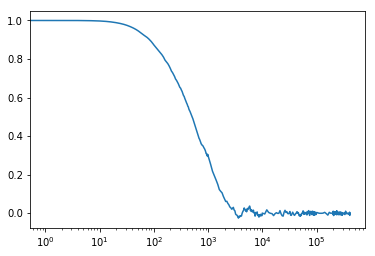

In [22]:
plt.plot(timesteps, scattering_values)
plt.xscale('log')

where the figure above shows a reasonable curve for the structural relaxation.

## Comparison of Structrual Relaxations

Currently I am computing structural relaxation using

$$ F_d(t) = \frac{1}{N} \langle \sum_i w_i(d,t) \rangle $$

where $d=0.4$. 
From the static structure calculation above,
I should be using a value of $d=0.6$,
so does this make a significant difference 
to how I am measuring the structural realxation?

In [23]:
def structural_relaxation(
    box: freud.box.Box, 
    init_position: numpy.ndarray, 
    current_position:numpy.ndarray,
    distance: float,
):
    displacements = numpy.linalg.norm(box.wrap(init_position - current_position), axis=1)
    return numpy.mean(displacements < distance) 

In [24]:
timesteps = []
relaxation_d03 = []
relaxation_d04 = []
relaxation_d06 = []
num_frames = 1000

init_snapshot = None

for index, snapshot in enumerate(sdanalysis.open_trajectory(filename)):
    if index > num_frames:
        break
        
    if index == 0:
        init_snapshot = snapshot

    box = freud.box.Box(
        Lx=snapshot.box[0],
        Ly=snapshot.box[1],
        is2D=True,
    )

    timesteps.append(snapshot.timestep)

    relaxation_d03.append(
        structural_relaxation(box, init_snapshot.position, snapshot.position, distance=0.3)
    )
    relaxation_d04.append(
        structural_relaxation(box, init_snapshot.position, snapshot.position, distance=0.4)
    )
    relaxation_d06.append(
        structural_relaxation(box, init_snapshot.position, snapshot.position, distance=0.6)
    )

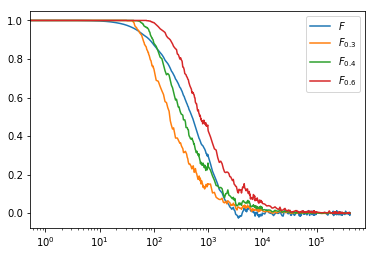

In [25]:
plt.plot(timesteps, scattering_values, label=r"$F$")
plt.plot(timesteps, relaxation_d03, label=r"$F_{0.3}$")
plt.plot(timesteps, relaxation_d04, label=r"$F_{0.4}$")
plt.plot(timesteps, relaxation_d06, label=r"$F_{0.6}$")
plt.xscale('log')
plt.legend()

## Comparison of computational time

The calculation of the intermediate scattering function 
requires more calculation than that of the structural relaxation function,
however how much additional time is it?

In [26]:
%timeit intermediate_scattering_function(box, init_snapshot.position, snapshot.position, wave_number)

1.53 ms ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%timeit structural_relaxation(box, init_snapshot.position, snapshot.position, distance=0.6)

853 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The results above shows that 
there isn't too much of an additional computational cost 
in calculating the structural relaxation 
through the intermediate scattering function.